# Cross-validation Revisited

In the [previous chapter](../4_reducing_complexity/leakage.ipynb), we have seen the dangers of leakage.
Here, we will see how the idea of cross-validation can defeat leakage and allow feature selection and hyperparameter optimization without having to be worries about the validity of the performance estimates.

## Feature selection without leakage

We will begin with revisiting the SelectKBest example from the [previous chapter](../4_reducing_complexity/practice_regularization.ipynb), but instead of using a separate, independent dataset, here we will incorporate the feature selection into the cross-validation scheme.

To do this, we "fold out" the cross-validation, that is, instead of the scikit-learn shorthand function, we reach back to the for loop-based implementation, as in [chapter 3](../3_cross_validation/cv.ipynb).

In [1]:
#imports
!pip install scikit-learn > /dev/null 2>&1
import warnings
warnings.simplefilter("ignore")
import numpy as np # can never harm!!
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge

MAE =  8.860477094980913 years


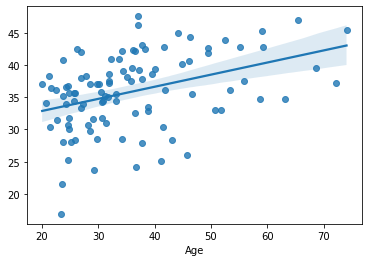

In [2]:
#load data
df_full = pd.read_csv("https://raw.githubusercontent.com/pni-lab/predmod_lecture/master/ex_data/IXI/ixi.csv")

# select a subset for cross-validation
df_cv = df_full.loc[:100, :]
# unlike in the previous chapter, here we don't fetch an independnet dataset.
# df_ext = df_full.loc[100:200, :]

# names of the columns to be used
target = 'Age'
features = df_cv.columns[2:]

cv=KFold(5)

cv_predictions = np.zeros(len(df_cv))
for train_index, test_index in cv.split(df_cv):
    # we select and fetch the best 5 feature in the actual training set
    k_best_selector = SelectKBest(k=5).fit(y=df_cv.loc[train_index, target], X=df_cv.loc[train_index, features])
    k_best_festures_train = k_best_selector.transform(X=df_cv.loc[train_index, features])
    # next, we train the model on these features
    model = LinearRegression().fit(y=df_cv.loc[train_index, target], X=k_best_festures_train)

    # Now we fetch the *same* 5 features from the test set (although they might not be the "top 5" there)
    k_best_festures_test = k_best_selector.transform(X=df_cv.loc[test_index, features])
    # we store the predictions for this fold
    cv_predictions[test_index] = model.predict(X=k_best_festures_test)

sns.regplot(x=df_cv[target], y=cv_predictions)
print('MAE = ', mean_absolute_error(y_true=df_cv[target], y_pred=cv_predictions), 'years')

The results are pretty much comparable to those in the previous section. Without having to use an independent dataset.
But, unfortunately, the code got longer and dirtier.

But no worries, scikit-learn got shorthands for this, too!

Namely, with scikit-learn, you can create arbitrary, multi-stage machine learning [pipelines](https://scikit-learn.org/stable/modules/compose.html#pipeline) and have them cross-validated automatically.
Everything can be put into a pipeline, as long as it has properly implemented `fit` and `transform` functions.

Let's have a look at it in practice:

MAE =  8.860477094980913 years


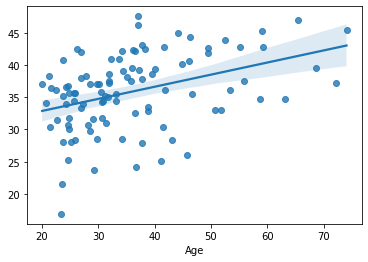

In [3]:
from sklearn.pipeline import Pipeline

multistage_model = Pipeline(steps=[('feature_selection', SelectKBest(k=5)),
                       ('regression_model', LinearRegression())])

# The important change is:                    VVV here VVV
cv_predictions = cross_val_predict(estimator=multistage_model, y=df_cv[target], X=df_cv[features], cv=KFold(5))

sns.regplot(x=df_cv[target], y=cv_predictions)
print('MAE = ', mean_absolute_error(y_true=df_cv[target], y_pred=cv_predictions), 'years')

The same result as above. Bitwise.
But with much less (and cleaner) code.

As you can see from the syntax, arbitrarily complex pipelines can be constructed, with as many steps as needed.
Scikit-learn will take care that everything inside a pipeline is properly cross-validated and leakage-free.

But what if we want to fine-tune the k-parameter?

## Hyperparameter optimization without leakage

As demonstrated in the [previous chapter](../4_reducing_complexity/leakage.ipynb), hyperparamter optimization, similarly to feature selection, has to take place on a dataset that is independent of the test dataset. Otherwise our performance estimates will be overly optimistic.

At this point, you might say: cross-validation can solve this, too, for sure!
You are right!

But how?

If we would do it like we did with the feature selection, the hyperparameter-tuning would turn into an overfitting competition.

The key is that we must apply the cross-validation trick once again:
- we will do an inner cross-validation where the "best" hyperparamters are determined.
- and an outer cross-validation, where the performance of the previously identifies "best model" is evaluated on the independent hold-out set.

In this scheme, in each iteration, we are dividing the data into 3 samples:
- training sample
- test sample (on which we optimize the hyperparameters)
- validation sample (on which we calculate the unbiased performance estimates of the best model)

**ToDo: figure**

Before we look at the code, we must get familiar with [`GridSearchCV`](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) of scikit-learn.
`GridSearchCV` is similar to `cross_val_score`; it cross-validates the model it gets, with the data it gets.
But, additionally, you can provide a list of hyperparameter values for `GridSearchCV`.
It then runs the model with all possible combinations of all hyperparameters and selects the model which gives the best cross-validated results.
Finally, it fits the best model on all data it sees, i.e. without cross-validation.

Putting `GridSearchCV` inside of another cross-validation loop allows probing this best model in an unbiased way.

Here's the code:

{'feature_selection__k': 6} -8.74431319959252
{'feature_selection__k': 6} -8.52338625510901
{'feature_selection__k': 4} -8.669411483361305
{'feature_selection__k': 4} -9.322312975508792
{'feature_selection__k': 4} -8.0658978734489
MAE =  8.694672158559634 years


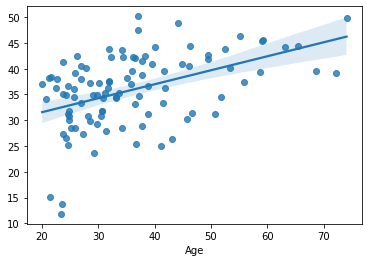

In [4]:
df_full = pd.read_csv("https://raw.githubusercontent.com/pni-lab/predmod_lecture/master/ex_data/IXI/ixi.csv")
df_cv = df_full.loc[:100, :]
target = 'Age'
features = df_cv.columns[2:]

cv_outer=KFold(5)
cv_inner=KFold(5)

multistage_model = Pipeline(steps=[('feature_selection', SelectKBest()),
                       ('regression_model', LinearRegression())])

hyperparameter_grid = {'feature_selection__k': [4, 5, 6]},

# we create the GridSerachCV:
clf = GridSearchCV(estimator=multistage_model,
                   param_grid=hyperparameter_grid,
                   cv=cv_inner,
                   scoring='neg_mean_absolute_error',
                   n_jobs=-1)


cv_predictions = np.zeros(len(df_cv))

# outer cross validation
for outer_train_index, validation_index in cv_outer.split(df_cv):

    # inner cross validations, realised by a GridSearchCV
    clf.fit(y = df_cv.loc[outer_train_index,target], X=df_cv.loc[outer_train_index,features])

    print(clf.best_params_, clf.best_score_)

    # now we call the predeict function of GridSearchCV, which calls the predict function of the best model, as finalized within the gridsearch
    cv_predictions[validation_index] = clf.predict(X=df_cv.loc[validation_index,features])

sns.regplot(x=df_cv[target], y=cv_predictions)
print('MAE = ', mean_absolute_error(y_true=df_cv[target], y_pred=cv_predictions), 'years')

Slightly better performance.
But the there is no consensus among the models regarding the best k.
This is not necessarily a problem. As discussed earlier, the cross-validation characterizes not a single model but a whole family of models.
Of course the broader the family of models is, the less specific the estimates to our model will be.

Therefore, stability of the hypermarkets inside a nested cross-validation can always be considered as a good sign.
On the other hand, the lack of agreement between cross-validation iterations might mean, that you don't have enough data for so many hyperparameters.

Now that we know the framework of nested cross-validation, let's fit some other models:

MAE =  7.2278935084762495 years


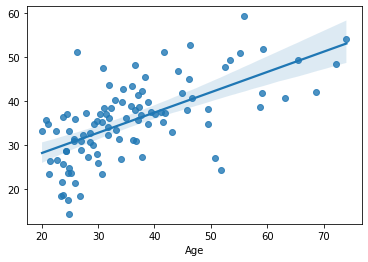

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df_cv = df_full.loc[:100, :] # we fetch a bit more data, as we will have a more complex model.
target = 'Age'
features = df_cv.columns[2:]

cv_outer=KFold(5)
cv_inner=KFold(5)

multistage_model = Pipeline(steps=[('feature_standardization', StandardScaler()),
                                   ('dimensionality_reduction', PCA()),
                                   ('regression_model', Ridge())])

hyperparameter_grid = {
    'dimensionality_reduction__n_components': [1,5,10,20,30,40],
    'regression_model__alpha': [0.1, 1, 10]
}

# we create the GridSerachCV:
clf = GridSearchCV(estimator=multistage_model,
                   param_grid=hyperparameter_grid,
                   cv=cv_inner,
                   scoring='neg_mean_absolute_error',
                   n_jobs=-1)

cv_predictions = cross_val_predict(estimator=clf, y=df_cv[target], X=df_cv[features], cv=cv_outer)

sns.regplot(x=df_cv[target], y=cv_predictions)
print('MAE = ', mean_absolute_error(y_true=df_cv[target], y_pred=cv_predictions), 'years')


MAE =  7.269020953383818 years


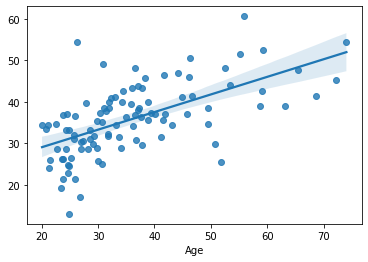

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso

df_cv = df_full.loc[:100, :] # we fetch a bit more data, as we will have a more complex model.
target = 'Age'
features = df_cv.columns[2:]

cv_outer=KFold(5)
cv_inner=KFold(5)

multistage_model = Pipeline(steps=[('feature_standardization', StandardScaler()),
                                   ('dimensionality_reduction', PCA()),
                                   ('regression_model', Lasso())])

hyperparameter_grid = {
    'dimensionality_reduction__n_components': [1,5,10,20,30,40],
    'regression_model__alpha': [0.1, 1, 10]
}

# we create the GridSerachCV:
clf = GridSearchCV(estimator=multistage_model,
                   param_grid=hyperparameter_grid,
                   cv=cv_inner,
                   scoring='neg_mean_absolute_error',
                   n_jobs=-1)

cv_predictions = cross_val_predict(estimator=clf, y=df_cv[target], X=df_cv[features], cv=cv_outer)

sns.regplot(x=df_cv[target], y=cv_predictions)
print('MAE = ', mean_absolute_error(y_true=df_cv[target], y_pred=cv_predictions), 'years')
